In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import math
import pandas as pd

In [8]:
def ray_line_intersection(O, theta, A, B):
    x1, y1 = A
    x2, y2 = B

    # Ray parametric equations
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)

    # Line parametric equations
    dx = x2 - x1
    dy = y2 - y1

    # Solve the system of equations
    det =  cos_theta * dy - dx * sin_theta

    if det ==0:
        return np.array([np.nan,np.nan])

    t = ((A-O)[0]*dy-(A-O)[1]*dx)/det
    u = ((A-O)[0]*sin_theta-(A-O)[1]*cos_theta)/det


    if t >= 0 and 0 <= u <= 1:
        # Intersection point
        P = O+t*np.array([cos_theta,sin_theta])
        return P
    else:
        # No intersection
        return np.array([np.nan,np.nan])

In [9]:
def rotate_rectangle(offset,width, height, theta):
    half_width = width / 2
    half_height = height / 2

    # Calculate rotated corner points
    top_left = np.array([-half_width, half_height])
    top_right = np.array([half_width, half_height])
    bottom_left = np.array([-half_width, -half_height])
    bottom_right = np.array([half_width, -half_height])

    # Rotate the corner points
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])
    rotated_top_left = offset + np.dot(rotation_matrix, top_left)
    rotated_top_right = offset + np.dot(rotation_matrix, top_right)
    rotated_bottom_left = offset + np.dot(rotation_matrix, bottom_left)
    rotated_bottom_right = offset + np.dot(rotation_matrix, bottom_right)
    return rotated_top_left,rotated_top_right,rotated_bottom_right,rotated_bottom_left

In [10]:
def ray_rectangle_intersection(O,theta_ray,offset,width,height,theta_rect,flag_fig = False):
    # get angles of rectangle    
    corners =  rotate_rectangle(offset,width, height,theta_rect)
    n_corners = len(corners)
    #get ray-line intersections for all sides
    intersect = []
    for i in range(n_corners):
        intersect_point = ray_line_intersection(O, theta_ray, corners[i], corners[(i+1)%n_corners])
        if not any(np.isnan(intersect_point)):
            intersect.append(intersect_point)

    if flag_fig:
        stacked = np.vstack(corners)
        plt.scatter(stacked[:,0],stacked[:,1])
        plt.plot([O[0],O[0]+5*np.cos(theta_ray)],[O[1],O[1]+5*np.sin(theta_ray)])
        plt.show()
    if intersect:
        return min(intersect, key=lambda point: point[1])
    else:
        return np.array([100,100])

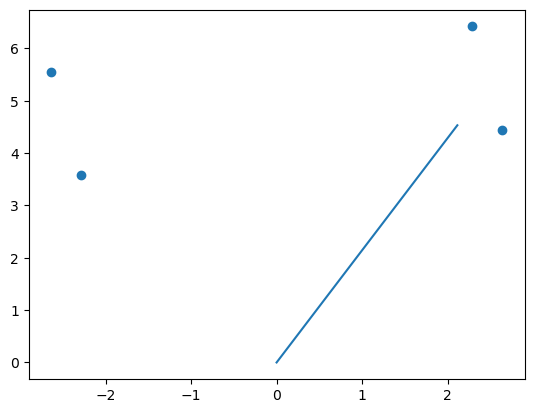

In [11]:
temp = ray_rectangle_intersection([0,0],math.radians(65),[0,5],5,2,math.radians(10),flag_fig=True)

In [12]:
def lidar_rectangle_scan(O,theta_range,theta_step,offset,width,height,rect_angle):
    scan_points = []
    theta = theta_range[0]
    while theta <=theta_range[1]:
        # Scan through the range given
        point = ray_rectangle_intersection(O,theta,offset,width,height,rect_angle,flag_fig=False)
        scan_points.append(point)
        theta +=theta_step
    return scan_points

In [13]:
angle_list = np.linspace(-20,20,100)
d_list = np.linspace(20,50,100)

In [14]:
    file_path_list = [
        r"C:\Users\Enrico Del Re\Documents\Spiki\spiki_robust\generate_measurements\dataset_10_10.csv",
        r"C:\Users\Enrico Del Re\Documents\Spiki\spiki_robust\generate_measurements\dataset_20_20.csv",
        r"C:\Users\Enrico Del Re\Documents\Spiki\spiki_robust\generate_measurements\dataset_100_100.csv",
        r"C:\Users\Enrico Del Re\Documents\Spiki\spiki_robust\generate_measurements\dataset_200_200.csv",
        r"C:\Users\Enrico Del Re\Documents\Spiki\spiki_robust\generate_measurements\dataset_300_300.csv",
        r"C:\Users\Enrico Del Re\Documents\Spiki\spiki_robust\generate_measurements\dataset_10000_10000.csv",
        r"C:\Users\Enrico Del Re\Documents\Spiki\spiki_robust\generate_measurements\dataset_20000_20000.csv"
    ]

In [15]:
import os
os.path.basename(file_path_list[0])[:-4]

'dataset_10_10'

In [16]:
20+15

35

In [22]:
for i in [10,20,100,200,300,10000]:
    angle_n_p = i
    dist_n_p = i
    angle_list_random = np.random.normal(0, 5, size=angle_n_p)
    d_list_random  =np.random.normal(35, 5, size=dist_n_p)
    angle_min = -20
    angle_max = 20
    dist_min = 20
    dist_max = 50
    angle_list_random = np.clip(angle_list_random,angle_min,angle_max)
    d_list_random = np.clip(d_list_random,dist_min,dist_max)
    points_random = list(zip(angle_list_random, d_list_random))

    df_list = []
    # angle_list = np.linspace(-20,20,10)
    for p in points_random:
        for type in [0,1]:
            #0=Car
            #1=Semi-truck
            theta_range = np.radians([80,110])
            theta_step = np.radians(2)
            O = np.array([0, 0])  # Ray origin
            offset = [0,p[1]]
            if type==0:
                width = 4.5
                height = 1.8
            elif type==1:
                width = 22
                height = 2.5
            angle = np.radians(p[0])
            scan = lidar_rectangle_scan(O,theta_range,theta_step,offset,width,height,angle)
            data = pd.DataFrame(np.concatenate(scan).reshape(-1,30))
            data['angle'] = angle
            data['distance'] = offset[1]
            data['class'] = type
            df_list.append(data)
    full_df_random = pd.concat(df_list,axis=0,ignore_index=True)
    full_df_random.to_csv(f"dataset_gaussian_{angle_n_p}_{dist_n_p}.csv",index=False)

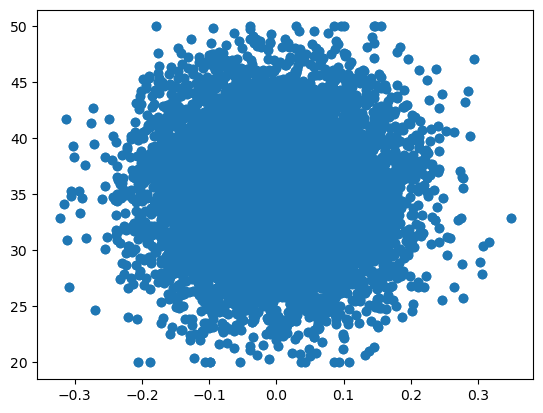

In [23]:
plt.scatter(data=full_df_random,x="angle",y="distance")
plt.show()

In [14]:
df_list = []
# angle_list = np.linspace(-20,20,10)
for d in d_list:
    for ang in angle_list:
        for type in [0,1]:
            #0=Car
            #1=Semi-truck
            theta_range = np.radians([80,110])
            theta_step = np.radians(2)
            O = np.array([0, 0])  # Ray origin
            offset = [0,d]
            if type==0:
                width = 4.5
                height = 1.8
            elif type==1:
                width = 22
                height = 2.5
            angle = np.radians(ang)
            scan = lidar_rectangle_scan(O,theta_range,theta_step,offset,width,height,angle)
            data = pd.DataFrame(np.concatenate(scan).reshape(-1,30))
            data['angle'] = angle
            data['distance'] = offset[1]
            data['class'] = type
            df_list.append(data)

In [15]:
full_df = pd.concat(df_list,axis=0,ignore_index=True)

In [16]:
full_df.to_csv("lidar_car_truck.csv",index=False)

In [18]:
len(full_df)

20000

In [21]:
selected_rows1 = full_df.sample(n=int(len(full_df)*0.3))
selected_rows2 = full_df.sample(n=int(len(full_df)*0.5))
selected_rows3 = full_df.sample(n=int(len(full_df)*0.8))
selected_rows1.to_csv("selected_rows1.csv",index=False)
selected_rows2.to_csv("selected_rows2.csv",index=False)
selected_rows3.to_csv("selected_rows3.csv",index=False)

In [286]:
np.shape(full_df.drop(['angle','distance','class'],axis=1).values)

(20, 30)

In [290]:
df = pd.read_csv("lidar_car_truck.csv",index_col=None)

In [291]:
df

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,angle,distance,class
0,100.000000,100.000000,100.000000,100.000000,1.983399,18.870785,1.298514,18.569619,0.656624,18.803248,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,-0.349066,20,0
1,3.093455,17.543852,2.496180,17.761243,1.889972,17.981884,1.273116,18.206402,0.643780,18.435461,...,20.235264,-5.119481,20.533116,-5.977305,20.845339,-6.879790,21.173817,-0.349066,20,1
2,100.000000,100.000000,100.000000,100.000000,1.960463,18.652557,1.307753,18.701742,0.659382,18.882229,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,-0.271496,20,0
3,3.143457,17.827432,2.529501,17.998338,1.909832,18.170835,1.282833,18.345372,0.646817,18.522419,...,19.878677,-5.010828,20.097332,-5.828049,20.324821,-6.681090,20.562281,-0.271496,20,1
4,100.000000,100.000000,100.000000,100.000000,1.965120,18.696870,1.316323,18.824290,0.661847,18.952825,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,-0.193925,20,0
5,3.191404,18.099350,2.561095,18.223139,1.928389,18.347398,1.291719,18.472436,0.649476,18.598569,...,19.541893,-4.909339,19.690284,-5.690065,19.843614,-6.499215,20.002526,-0.193925,20,1
6,100.000000,100.000000,100.000000,100.000000,1.982492,18.862153,1.324349,18.939079,0.664062,19.016255,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,-0.116355,20,0
7,3.237898,18.363034,2.591377,18.438602,1.945905,18.514047,1.299908,18.589553,0.651807,18.665305,...,19.218972,-4.813041,19.304054,-5.560397,19.391408,-6.329873,19.481346,-0.116355,20,1
8,100.000000,100.000000,100.000000,100.000000,1.999266,19.021742,1.331941,19.047637,0.666060,19.073476,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,-0.038785,20,0
9,3.283498,18.621645,2.620716,18.647364,1.962601,18.672901,1.307514,18.698322,0.653846,18.723687,...,18.904991,-4.720335,18.932230,-5.436701,18.960028,-6.169729,18.988473,-0.038785,20,1


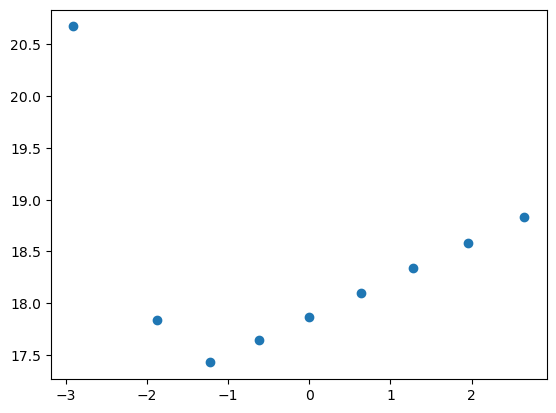

In [236]:
stacked = np.vstack([j for j in scan if j[0]<50])
plt.scatter(stacked[:,0],stacked[:,1])
plt.show()

In [147]:
# Example usage
O = np.array([0, 0])  # Ray origin
theta = math.radians(90)  # Angle in radians
A = np.array([-2,2])  # Line segment start point
B = np.array([5,5]) # Line segment end point

intersection = ray_line_intersection(O, theta, A, B)
print(intersection)

[1.74949543e-16 2.85714286e+00]


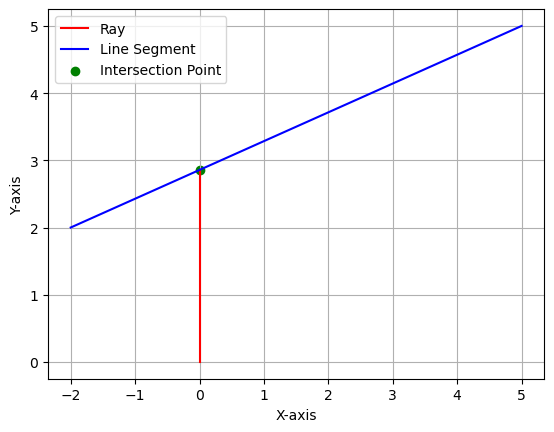

In [148]:
# Plot the ray and the line segment
plt.figure()
plt.plot([O[0], intersection[0]], [O[1], intersection[1]], 'r-', label='Ray')
plt.plot([A[0], B[0]], [A[1], B[1]], 'b-', label='Line Segment')
plt.scatter(*intersection, color='green', label='Intersection Point')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()
plt.show()

In [7]:
def generate_rotated_rectangle_points(width, height, angle_degrees, num_points):
    theta = np.radians(angle_degrees)
    half_width = width / 2
    half_height = height / 2

    # Calculate rotated corner points
    top_left = np.array([-half_width, half_height])
    top_right = np.array([half_width, half_height])
    bottom_left = np.array([-half_width, -half_height])
    bottom_right = np.array([half_width, -half_height])

    # Rotate the corner points
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta), np.cos(theta)]])
    rotated_top_left = np.dot(rotation_matrix, top_left)
    rotated_top_right = np.dot(rotation_matrix, top_right)
    rotated_bottom_left = np.dot(rotation_matrix, bottom_left)
    rotated_bottom_right = np.dot(rotation_matrix, bottom_right)

    # Calculate points for the visible sides
    if 0 < angle_degrees < 90:
        visible_side_1_x = np.linspace(rotated_top_left[0], rotated_bottom_left[0], num_points)
        visible_side_1_z = np.linspace(rotated_top_left[1], rotated_bottom_left[1], num_points)
        visible_side_2_x = np.linspace(rotated_bottom_left[0], rotated_bottom_right[0], num_points)
        visible_side_2_z = np.linspace(rotated_bottom_left[1], rotated_bottom_right[1], num_points)
    elif angle_degrees == 90:
        visible_side_x = np.linspace(rotated_top_left[0], rotated_bottom_left[0], num_points)
        visible_side_z = np.linspace(rotated_top_left[1], rotated_bottom_left[1], num_points)
        return np.array([visible_side_x,visible_side_z])
    elif angle_degrees == 0:
        visible_side_x = np.linspace(rotated_bottom_left[0], rotated_bottom_right[0], num_points)
        visible_side_z = np.linspace(rotated_bottom_left[1], rotated_bottom_right[1], num_points)
        return np.array([visible_side_x,visible_side_z])
    elif 0 > angle_degrees > -90:
        visible_side_1_x = np.linspace(rotated_bottom_left[0], rotated_bottom_right[0], num_points)
        visible_side_1_z = np.linspace(rotated_bottom_left[1], rotated_bottom_right[1], num_points)
        visible_side_2_x = np.linspace(rotated_bottom_right[0], rotated_top_right[0], num_points)
        visible_side_2_z = np.linspace(rotated_bottom_right[1], rotated_top_right[1], num_points)
    else:
        visible_side_1_x = np.linspace(rotated_top_left[0], rotated_top_right[0], num_points)
        visible_side_1_z = np.linspace(rotated_top_left[1], rotated_top_right[1], num_points)
        visible_side_2_x = np.linspace(rotated_top_right[0], rotated_bottom_right[0], num_points)
        visible_side_2_z = np.linspace(rotated_top_right[1], rotated_bottom_right[1], num_points)
    x_boundary = np.concatenate((visible_side_1_x, visible_side_2_x))
    z_boundary = np.concatenate((visible_side_1_z, visible_side_2_z))

    rectangle_points = np.array([x_boundary, z_boundary])
    return rectangle_points

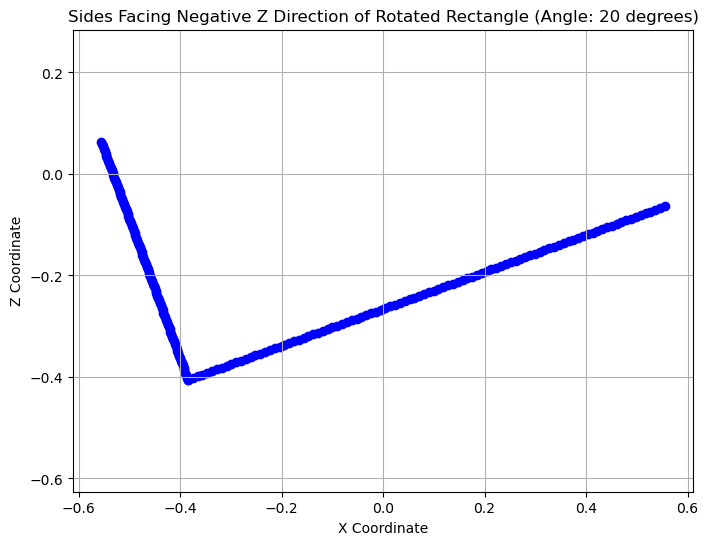

In [11]:
# Rectangle dimensions
width = 1.0
height = 0.5

# Rotation angle in degrees (can be larger than 90)
angle_degrees = 20

# Number of points along each edge
num_points = 100

# Generate points on the rotated rectangle boundaries
points = generate_rotated_rectangle_points(width, height, angle_degrees, num_points)

# Plot the points
plt.figure(figsize=(8, 6))
plt.scatter(points[0], points[1], marker='o', color='blue')
plt.xlabel('X Coordinate')
plt.ylabel('Z Coordinate')
plt.title(f'Sides Facing Negative Z Direction of Rotated Rectangle (Angle: {angle_degrees} degrees)')
plt.grid(True)
plt.axis('equal')
plt.show()

In [4]:
np.shape(points)

(2, 100)

In [5]:
def generate_lidar_measurements(objects, noise_std=0.05):
    measurements = []
    for obj in objects:
        angle_degrees, width, height = obj
        x, z = generate_rotated_rectangle(angle_degrees, width, height, num_points=200)
        noise = np.random.normal(0, noise_std, len(x))
        z_with_noise = z + noise
        measurements.append((x, z_with_noise))
    return measurements

In [6]:
# Define objects (angle_degrees, width, height)
objects = [
    (15, 1.0, 0.5),
    (-30, 0.8, 0.3),
    (60, 1.2, 0.6)
]

# Generate LiDAR measurements
lidar_measurements = generate_lidar_measurements(objects)

# Plot the generated measurements
plt.figure(figsize=(8, 6))
for x, z in lidar_measurements:
    plt.plot(x, z, marker='o', linestyle='-', linewidth=2)
plt.xlabel('X Coordinate')
plt.ylabel('Distance (Z Coordinate)')
plt.title('LiDAR Measurements of Rotated Rectangular Objects')
plt.grid(True)
plt.show()

NameError: name 'generate_rotated_rectangle' is not defined

In [23]:
list_data = [[0.1, 20.0], [0.2, 30.0]]
print(list_data)
df_list = []
for p in list_data:
    for type in [0,1]:
        #0=Car
        #1=Semi-truck
        theta_range = np.radians([80,110])
        theta_step = np.radians(2)
        O = np.array([0, 0])  # Ray origin
        offset = [0,p[1]]
        if type==0:
            width = 4.5
            height = 1.8
        elif type==1:
            width = 22
            height = 2.5
        angle = np.radians(p[0])
        scan = lidar_rectangle_scan(O,theta_range,theta_step,offset,width,height,angle)
        data = pd.DataFrame(np.concatenate(scan).reshape(-1,30))
        data['angle'] = angle
        data['distance'] = offset[1]
        data['class'] = type
        df_list.append(data)
full_df = pd.concat(df_list,axis=0,ignore_index=True)
print(df_list)
print(full_df)

[[0.1, 20.0], [0.2, 30.0]]
[       0      1      2      3         4          5         6         7   
0  100.0  100.0  100.0  100.0  2.007859  19.103503  1.335765  19.10233  \

          8          9  ...     23     24     25     26     27     28     29   
0  0.667027  19.101163  ...  100.0  100.0  100.0  100.0  100.0  100.0  100.0  \

      angle  distance  class  
0  0.001745      20.0      0  

[1 rows x 33 columns],           0         1         2          3         4          5         6   
0  3.307148  18.75577  2.635787  18.754598  1.971066  18.753438  1.311288  \

           7         8          9  ...         23        24         25   
0  18.752287  0.654804  18.751141  ...  18.743045 -4.672866  18.741842  \

         26         27        28         29     angle  distance  class  
0 -5.373786  18.740619 -6.088791  18.739371  0.001745      20.0      1  

[1 rows x 33 columns],        0      1      2      3      4      5         6          7         8   
0  100.0  100.0  100.0  

In [24]:
from sklearn.preprocessing import StandardScaler

In [45]:
data = np.random.normal(loc=2, scale=0.5, size=1000).reshape(-1, 1)

In [46]:
np.shape(data)

(1000, 1)

In [48]:
scaler = StandardScaler()
scaler.fit(data)
print(scaler.mean_)
print(scaler.scale_)

[1.98815597]
[0.49620953]


In [49]:
data_scaled = scaler.transform(data)

In [50]:
data_manual = (data-scaler.mean_)/scaler.scale_

In [51]:
np.max(abs(data_manual-data_scaled))

0.0